In [1]:
# section 1 load all the necessary modules and packages
import glob
import time
import netCDF4 as nc4
import numpy as np
import pandas as pd
import xarray as xr
# not neccessary for the function but for visualziation
import matplotlib.pyplot as plt
import warnings
import sys
import os
import platform
import shutil


In [2]:
###########################
# replacing string function
###########################
def replace_string (file_in, file_out, string_old, string_replaced):
    with open(file_in, "r+") as text_file:
        texts = text_file.read()
        for i in np.arange(len(string_old)):
            texts = texts.replace(string_old[i], string_replaced[i])
    with open(file_out, "w") as text_file:
        text_file.write(texts)


[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013]
<xarray.Dataset>
Dimensions:  (time: 12784)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2013-12-31
    lon      float64 33.12
    lat      float64 -0.875
Data variables:
    prec     (time) float32 0.582 1.751 3.802 1.043 ... 0.913 4.721 12.09 17.83
    evapw    (time) float32 4.686 4.749 5.318 5.848 ... 6.279 5.527 5.106 5.905
    runoff   (time) float32 3.843 3.76 3.749 3.016 ... 0.9205 0.1361 6.502
Attributes:
    CDI:                        Climate Data Interface version 2.0.5 (https:/...
    Conventions:                CF-1.6
    history:                    Fri Jul 28 23:54:02 2023: cdo sellonlatbox,28...
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    history_of_appended_files:  Mon Jun  8 23:26:42 2020: Appended file runof...
    CDO:   

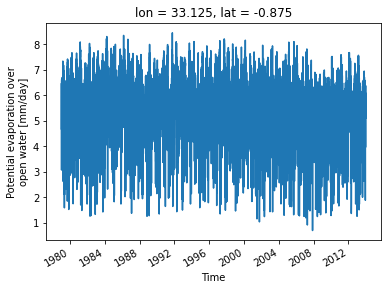

In [21]:
###########################
# get the evaporation for lake victoria 
###########################
file_names = sorted(glob.glob('../mizuRoute/input/mizuRoute_mswep_v1_*_subset.nc'))

datasets = [xr.open_dataset(file_name) for file_name in file_names]

merged_dataset = xr.concat(datasets, dim='time')

# number of years
time_variable = merged_dataset['time']
years = time_variable.dt.year
years = np.array(years)
n_years = np.unique(years)
print(n_years)


merged_dataset_slice = merged_dataset.sel(lat=-1.00, lon=33.00, method='nearest')

print(merged_dataset_slice)
merged_dataset_slice['evapw'].plot()


average_evap = sum(np.array(merged_dataset_slice['evapw'][:]))/len(n_years)

print(average_evap)

# get the ratio for scale
other_evap = np.array([average_evap, 1550, 1350, 1130, 1520, 1450, 1500, 1370, 1590, 1470, 1475, 1590, 1595, 1400])

# creat the scale factors
scales = other_evap/average_evap

# the control to create the restart file
m = 0
job_string = ''
for scale in scales:
    
    case_name = str(m)
    scale_value = str("{:.3f}".format(scale))
    
    replace_string ('../mizuRoute/settings/lake_victoria_temp.control',\
                    '../mizuRoute/settings/lake_victoria_'+case_name+'.control',\
                    ['case_temp','scale_factor_temp'],\
                    ['case_'+case_name+'_'+scale_value,scale_value])
    
    replace_string ('../mizuRoute/settings/lake_victoria_'+case_name+'.control',\
                    '../mizuRoute/settings/lake_victoria_'+case_name+'_restart.control',\
                    ['!<fname_state_in>'],\
                    ['<fname_state_in> '])
    
    m +=1
    
    # add to general string
    job_string = job_string + '# case'+ case_name +'\n'
    job_string = job_string + './route_runoff.exe ./settings/lake_victoria_'+case_name+'.control \n' +\
                              'mv case_'+case_name+'_'+scale_value+'.r.2014-01-01-00000.nc case_'+case_name+'_'+scale_value+'.r.1979-01-01-00000.nc \n'+\
                              './route_runoff.exe ./settings/lake_victoria_'+case_name+'_restart.control \n'
    job_string = job_string + '\n'
    
    

shutil.copy('../mizuRoute/lake_victoria_temp.submit', '../mizuRoute/lake_victoria.submit')
with open('../mizuRoute/lake_victoria.submit', "a") as file:
    file.write(job_string)
    